In [21]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import torch
import torch.nn as nn
from scipy import ndimage
from scipy.ndimage import zoom
import torch.nn.functional as F # change

config = {
    'img_size': 128,
    'depth': 64
}


In [22]:
class Options:
    def __init__(self):
        self.n_seg_classes = 2
        self.learning_rate = 1e-3
        self.phase = 'test'
        self.batch_size = 4
        self.epochs = 100
        self.input_D = 64 # not used
        self.input_H = 128 # not used
        self.input_W = 128 # not used
        self.pretrain_path = 'pretrain/resnet_10.pth'
        self.new_layer_names = ['conv_seg']
        self.no_cuda = False
        self.model = 'resnet'
        self.gpu_id = [0]
        self.model_depth = 10
        self.resnet_shortcut = 'B'
        self.manual_seed = 27
        self.ci_test = False

        self.img_size = 128
        self.depth = 64
        self.weight_decay= 1e-8

opt = Options()

In [23]:

device = torch.device(f"cuda:{opt.gpu_id[0]}" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [24]:
def read_nifti_file(filepath):
    """Read and load volume"""
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan


def normalize(volume):
    """Normalize the volume"""
    min_hu = -1000
    max_hu = 400
    volume[volume < min_hu] = min_hu
    volume[volume > max_hu] = max_hu
    volume = (volume - min_hu) / (max_hu - min_hu)
    return volume.astype('float32')

def resize_volume(img, desired_width=128, desired_height=128, desired_depth=64):
    """Resize the volume"""
    # Compute zoom factors
    width_factor = desired_width / img.shape[0]
    height_factor = desired_height / img.shape[1]
    depth_factor = desired_depth / img.shape[-1]
    # Rotate volume by 90 degrees
    img = ndimage.rotate(img, 90, reshape=False)
    # Resize the volume using spline interpolated zoom (SIZ)
    img = zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img


def process_scan(path, is_mask_file = False):
    """Read and resize volume"""
    # Read scan
    volume = read_nifti_file(path)
    # Normalize
    volume = normalize(volume) if not is_mask_file else volume
    # Resize width, height and depth
    volume = resize_volume(
        volume, config['img_size'], config['img_size'], config['depth']
    )
    return volume


In [25]:
# Create directories
output_dir = os.path.join(os.getcwd(), "MosMedData")
os.makedirs(output_dir, exist_ok=True)

test_scan_paths = [os.path.join(output_dir, "CT-1", x) for x in sorted(os.listdir(os.path.join(output_dir, "CT-1")))]
mask_scan_paths = [os.path.join(output_dir, "mask", x) for x in sorted(os.listdir(os.path.join(output_dir, "mask")))]


print("CT scans: " + str(len(test_scan_paths)) )

CT scans: 6


In [26]:
x_test = np.array([process_scan(path) for path in test_scan_paths])
y_test = np.array([1 for _ in range(len(test_scan_paths))])

print(
    'Number of samples in test are %d'
    % (x_test.shape[0])
)
mask_to_test = mask_scan_paths[0]
test_sample = x_test[0] # width, height, depth
test_tensor = torch.tensor(test_sample).permute(2, 0 ,1) # depth, width, height
print(test_tensor.shape)

Number of samples in test are 6
torch.Size([64, 128, 128])


In [47]:
class SaveFeatures:
    def __init__(self, model):
        self.activations = None
        self.gradients = None
        print("layer4 module", model.layer4)
        model.layer4[-1].register_forward_hook(self.activation_hook)
        model.layer4[-1].register_full_backward_hook(self.gradients_hook)
        
    def activation_hook(self, model, input, output):
        self.activations = output 
    
    def gradients_hook(self, module, grad_in, grad_out):
        self.gradients = grad_out[0]

In [48]:

__all__ = [
    'ResNet', 'resnet10', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
    'resnet152', 'resnet200'
]


def conv3x3x3(in_planes, out_planes, stride=1, dilation=1):
    # 3x3x3 convolution with padding
    return nn.Conv3d(
        in_planes,
        out_planes,
        kernel_size=3,
        dilation=dilation,
        stride=stride,
        padding=dilation,
        bias=False)


def downsample_basic_block(x, planes, stride, no_cuda=False):
    out = F.avg_pool3d(x, kernel_size=1, stride=stride)
    zero_pads = torch.Tensor(
        out.size(0), planes - out.size(1), out.size(2), out.size(3),
        out.size(4)).zero_()
    if not no_cuda:
        if isinstance(out.data, torch.cuda.FloatTensor):
            zero_pads = zero_pads.to(device)

    out = Variable(torch.cat([out.data, zero_pads], dim=1))

    return out


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, dilation=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3x3(inplanes, planes, stride=stride, dilation=dilation)
        self.bn1 = nn.BatchNorm3d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3x3(planes, planes, dilation=dilation)
        self.bn2 = nn.BatchNorm3d(planes)
        self.downsample = downsample
        self.stride = stride
        self.dilation = dilation

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, dilation=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv3d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm3d(planes)
        self.conv2 = nn.Conv3d(
            planes, planes, kernel_size=3, stride=stride, dilation=dilation, padding=dilation, bias=False)
        self.bn2 = nn.BatchNorm3d(planes)
        self.conv3 = nn.Conv3d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm3d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
        self.dilation = dilation

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self,
                 block,
                 layers,
                 sample_input_D,
                 sample_input_H,
                 sample_input_W,
                 num_seg_classes = 2,
                 shortcut_type='B',
                 no_cuda = False):
        self.inplanes = 64
        self.no_cuda = no_cuda
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv3d(
            1,
            64,
            kernel_size=7,
            stride=(2, 2, 2),
            padding=(3, 3, 3),
            bias=False)
            
        self.bn1 = nn.BatchNorm3d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool3d(kernel_size=(3, 3, 3), stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0], shortcut_type)
        self.layer2 = self._make_layer(
            block, 128, layers[1], shortcut_type, stride=2)
        self.layer3 = self._make_layer(
            block, 256, layers[2], shortcut_type, stride=1, dilation=2)
        self.layer4 = self._make_layer(
            block, 512, layers[3], shortcut_type, stride=1, dilation=4)
        self.conv_seg = nn.Sequential(
            nn.AdaptiveAvgPool3d((1, 1, 1)),
            nn.Flatten(),
            nn.Linear(512 * block.expansion, num_seg_classes)
        )

        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                m.weight = nn.init.kaiming_normal(m.weight, mode='fan_out')
            elif isinstance(m, nn.BatchNorm3d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, shortcut_type, stride=1, dilation=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            if shortcut_type == 'A':
                downsample = partial(
                    downsample_basic_block,
                    planes=planes * block.expansion,
                    stride=stride,
                    no_cuda=self.no_cuda)
            else:
                downsample = nn.Sequential(
                    nn.Conv3d(
                        self.inplanes,
                        planes * block.expansion,
                        kernel_size=1,
                        stride=stride,
                        bias=False), nn.BatchNorm3d(planes * block.expansion))

        layers = []
        layers.append(block(self.inplanes, planes, stride=stride, dilation=dilation, downsample=downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, dilation=dilation))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.conv_seg(x)

        return x

class resnet:
    def resnet10(**kwargs):
        """Constructs a ResNet-18 model.
        """
        model = ResNet(BasicBlock, [1, 1, 1, 1], **kwargs)
        return model


    def resnet18(**kwargs):
        """Constructs a ResNet-18 model.
        """
        model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
        return model


    def resnet34(**kwargs):
        """Constructs a ResNet-34 model.
        """
        model = ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)
        return model


    def resnet50(**kwargs):
        """Constructs a ResNet-50 model.
        """
        model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
        return model


    def resnet101(**kwargs):
        """Constructs a ResNet-101 model.
        """
        model = ResNet(Bottleneck, [3, 4, 23, 3], **kwargs)
        return model


    def resnet152(**kwargs):
        """Constructs a ResNet-101 model.
        """
        model = ResNet(Bottleneck, [3, 8, 36, 3], **kwargs)
        return model


    def resnet200(**kwargs):
        """Constructs a ResNet-101 model.
        """
        model = ResNet(Bottleneck, [3, 24, 36, 3], **kwargs)
        return model

def generate_model(opt):
    assert opt.model in [
        'resnet'
    ]

    if opt.model == 'resnet':
        assert opt.model_depth in [10, 18, 34, 50, 101, 152, 200]
        
        if opt.model_depth == 10:
            model = resnet.resnet10(
                sample_input_W=opt.input_W,
                sample_input_H=opt.input_H,
                sample_input_D=opt.input_D,
                shortcut_type=opt.resnet_shortcut,
                no_cuda=opt.no_cuda,
                num_seg_classes=opt.n_seg_classes)
        elif opt.model_depth == 18:
            model = resnet.resnet18(
                sample_input_W=opt.input_W,
                sample_input_H=opt.input_H,
                sample_input_D=opt.input_D,
                shortcut_type=opt.resnet_shortcut,
                no_cuda=opt.no_cuda,
                num_seg_classes=opt.n_seg_classes)
        elif opt.model_depth == 34:
            model = resnet.resnet34(
                sample_input_W=opt.input_W,
                sample_input_H=opt.input_H,
                sample_input_D=opt.input_D,
                shortcut_type=opt.resnet_shortcut,
                no_cuda=opt.no_cuda,
                num_seg_classes=opt.n_seg_classes)
        elif opt.model_depth == 50:
            model = resnet.resnet50(
                sample_input_W=opt.input_W,
                sample_input_H=opt.input_H,
                sample_input_D=opt.input_D,
                shortcut_type=opt.resnet_shortcut,
                no_cuda=opt.no_cuda,
                num_seg_classes=opt.n_seg_classes)
        elif opt.model_depth == 101:
            model = resnet.resnet101(
                sample_input_W=opt.input_W,
                sample_input_H=opt.input_H,
                sample_input_D=opt.input_D,
                shortcut_type=opt.resnet_shortcut,
                no_cuda=opt.no_cuda,
                num_seg_classes=opt.n_seg_classes)
        elif opt.model_depth == 152:
            model = resnet.resnet152(
                sample_input_W=opt.input_W,
                sample_input_H=opt.input_H,
                sample_input_D=opt.input_D,
                shortcut_type=opt.resnet_shortcut,
                no_cuda=opt.no_cuda,
                num_seg_classes=opt.n_seg_classes)
        elif opt.model_depth == 200:
            model = resnet.resnet200(
                sample_input_W=opt.input_W,
                sample_input_H=opt.input_H,
                sample_input_D=opt.input_D,
                shortcut_type=opt.resnet_shortcut,
                no_cuda=opt.no_cuda,
                num_seg_classes=opt.n_seg_classes)
    
    save_features = None
    if not opt.no_cuda:
        if len(opt.gpu_id) > 1:
            model = model.to(device) 
            save_features = SaveFeatures(model)
            model = nn.DataParallel(model, device_ids=opt.gpu_id)
            net_dict = model.state_dict() 
        else:
            import os
            os.environ["CUDA_VISIBLE_DEVICES"]=str(opt.gpu_id[0])
            model = model.to(device) 
            save_features = SaveFeatures(model)
            model = nn.DataParallel(model, device_ids=None)
            net_dict = model.state_dict()
    else:
        net_dict = model.state_dict()
    
    # load pretrain
    if opt.phase != 'test' and opt.pretrain_path:
        print ('loading pretrained model {}'.format(opt.pretrain_path))
        pretrain = torch.load(opt.pretrain_path)
        pretrain_dict = {k: v for k, v in pretrain['state_dict'].items() if k in net_dict.keys()}
         
        net_dict.update(pretrain_dict)
        model.load_state_dict(net_dict)

        new_parameters = [] 
        for pname, p in model.named_parameters():
            for layer_name in opt.new_layer_names:
                if pname.find(layer_name) >= 0:
                    new_parameters.append(p)
                    break

        new_parameters_id = list(map(id, new_parameters))
        base_parameters = list(filter(lambda p: id(p) not in new_parameters_id, model.parameters()))
        parameters = {'base_parameters': base_parameters, 
                      'new_parameters': new_parameters}

        return model, parameters

    return model, model.parameters(), save_features


In [49]:
model, _, save_features = generate_model(opt) 
print (model)

layer4 module Sequential(
  (0): BasicBlock(
    (conv1): Conv3d(256, 512, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(4, 4, 4), dilation=(4, 4, 4), bias=False)
    (bn1): BatchNorm3d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv3d(512, 512, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(4, 4, 4), dilation=(4, 4, 4), bias=False)
    (bn2): BatchNorm3d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv3d(256, 512, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
      (1): BatchNorm3d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
)
DataParallel(
  (module): ResNet(
    (conv1): Conv3d(1, 64, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3), bias=False)
    (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool3d(k

/tmp/ipykernel_2466452/3727041240.py:145: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  m.weight = nn.init.kaiming_normal(m.weight, mode='fan_out')


In [50]:
model.load_state_dict(torch.load("3d_image_classification.pth"))
model.eval()

with torch.no_grad():
    sample = test_tensor.unsqueeze(0).unsqueeze(0).to(device, dtype=torch.float32)
    prediction = model(sample)
    print(prediction, prediction.shape) 
    softmaxed_prediction = F.softmax(prediction, dim=1) 
    scores = softmaxed_prediction.squeeze().cpu().numpy()
    print(scores) 

class_names = ["normal", "abnormal"]
for score, name in zip(scores, class_names):
    print(f"This model is {score * 100:.2f} percent confident that CT scan is {name}")

tensor([[ 0.2603, -0.2594]], device='cuda:0') torch.Size([1, 2])
[0.6270881 0.3729119]
This model is 62.71 percent confident that CT scan is normal
This model is 37.29 percent confident that CT scan is abnormal


gradients:  (1, 512, 8, 16, 16)
activations:  (1, 512, 8, 16, 16)
pooled_grads:  (512,)
heatmap before transpose (8, 16, 16)
heatmap (16, 16, 8)
heatmap generated


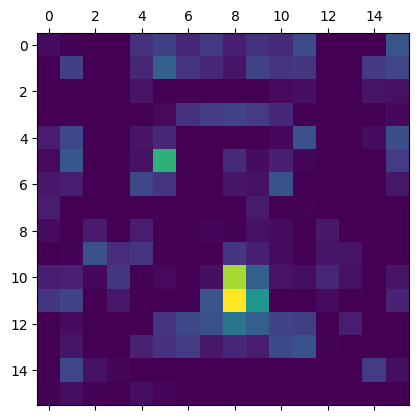

In [51]:
import torch
import torch.nn.functional as F
import numpy as np

def make_gradcam_heatmap(img_tensor, model, last_conv_layer_name, pred_index=None):
    """Generate class activation heatmap"""
    # First, we create a hook to store the activations and gradients
    activations = {}
    gradients = {}
    
    # def get_activation(name):
    #     def hook(model, input, output):
    #         activations[name] = output # change
    #     return hook
    
    # def get_gradients(name):
    #     def hook(module, grad_in, grad_out):
    #         gradients[name] = grad_out[0] # change
    #     return hook
    
    # # Register hooks in the last block of the last layer, to capture activations and gradients
    # # print(dict(model.named_modules()))
    # # last_conv_layer = dict(model.named_modules())[last_conv_layer_name]
    # # last_conv_layer[-1].register_forward_hook(get_activation(last_conv_layer_name))
    # # last_conv_layer[-1].register_backward_hook(get_gradients(last_conv_layer_name))
    
    # model.module.layer4[-1].register_forward_hook(get_activation(last_conv_layer_name))
    # model.module.layer4[-1].register_backward_hook(get_gradients(last_conv_layer_name))
    # print(model.module.layer4[-1])

    # Make a forward pass to get predictions and activations
    model.eval()
    output = model(img_tensor)
    
    if pred_index is None:
        pred_index = torch.argmax(output, dim=1)
    class_output = output[:, pred_index].squeeze()
    
    # Backward pass to get gradients
    model.zero_grad()
    class_output.backward(retain_graph=True)
    
    # Get the captured gradients and activations
    # activations = activations[last_conv_layer_name].detach().cpu().numpy()
    # gradients = gradients[last_conv_layer_name].detach().cpu().numpy()

    activations = save_features.activations.detach().cpu().numpy()
    gradients = save_features.gradients.detach().cpu().numpy()
    
    print("gradients: ", gradients.shape)
    print("activations: ", activations.shape)
    
    # Compute the weights
    pooled_grads = np.mean(gradients, axis=(0, 2, 3, 4))
    print("pooled_grads: ",pooled_grads.shape)
    
    for i in range(activations.shape[1]):
        activations[:, i, :, :, :] *= pooled_grads[i]
        
    heatmap = np.mean(activations, axis=1).squeeze()
    
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) # depth, width, height
    print("heatmap before transpose", heatmap.shape )
    heatmap = np.transpose(heatmap, (1, 2, 0)) # width, height, depth
    print("heatmap", heatmap.shape )
    return heatmap


last_conv_layer_name = 'layer4'
sample = test_tensor.unsqueeze(0).unsqueeze(0).to(device, dtype=torch.float32)

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(sample, model, last_conv_layer_name)

print("heatmap generated")

plt.matshow(np.squeeze(heatmap[:, :, 3]))
plt.show()

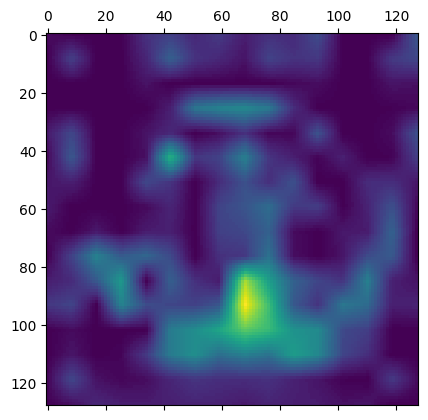

In [57]:
# Resize heatmap

def get_resized_heatmap(heatmap, shape):
    width = shape[0]
    height = shape[1]
    depth = shape[2]
    upscaled_heatmap = zoom(heatmap, (width / heatmap.shape[0], height / heatmap.shape[1], depth / heatmap.shape[2]), order=1)
    upscaled_heatmap = np.uint8(255 * upscaled_heatmap)
    return upscaled_heatmap

resized_heatmap = get_resized_heatmap(heatmap, test_sample.shape)
plt.matshow(np.squeeze(resized_heatmap[:, :, 30]))
plt.show()

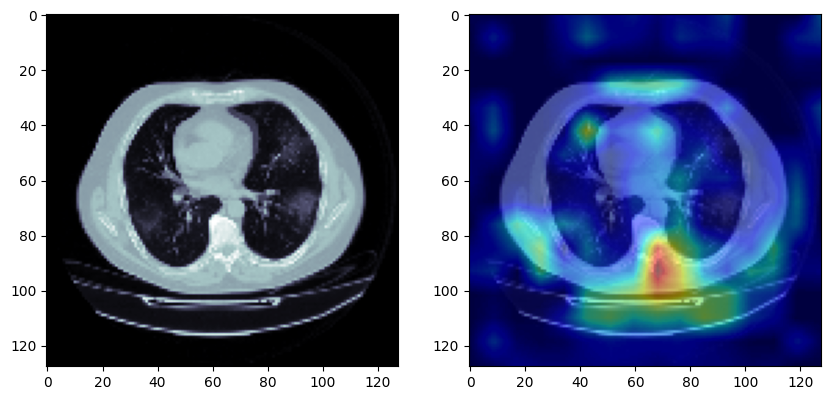

In [58]:
# Visualize heatmap
fig, ax = plt.subplots(1, 2, figsize=(10, 20))

ax[0].imshow(np.squeeze(test_sample[:, :, 30]), cmap='bone')
img0 = ax[1].imshow(np.squeeze(test_sample[:, :, 30]), cmap='bone')
img1 = ax[1].imshow(np.squeeze(resized_heatmap[:, :, 30]), cmap='jet', alpha=0.5, extent=img0.get_extent())
# plt.colorbar()
plt.show()


In [65]:
def read_mask_nifti_file(filepath):
    """Read and load volume"""
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan

def resize_mask_volume(img, desired_width=128, desired_height=128, desired_depth=64):
    """Resize the volume"""
    # Compute zoom factors
    width_factor = desired_width / img.shape[0]
    height_factor = desired_height / img.shape[1]
    depth_factor = desired_depth / img.shape[-1]

    # Rotate volume by 90 degrees
    img = ndimage.rotate(img, 90,  axes=(0, 1), reshape=False) # TODO why ??

    # Resize the volume using spline interpolated zoom (SIZ)
    img = zoom(img, (width_factor, height_factor, depth_factor), order=1)

    return img


mask_test_volume = read_mask_nifti_file(mask_to_test)
mask_test_volume = resize_mask_volume(mask_test_volume, config['img_size'], config['img_size'], config['depth'])

8092 [16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39
 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54]


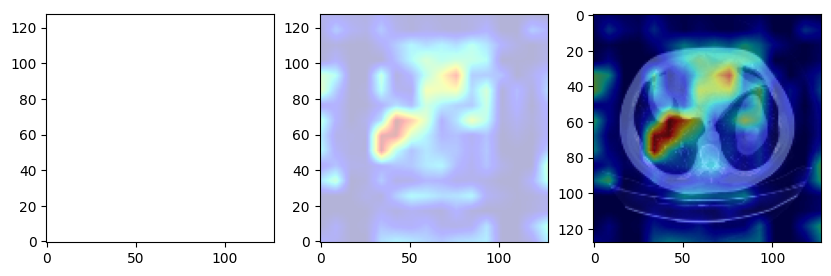

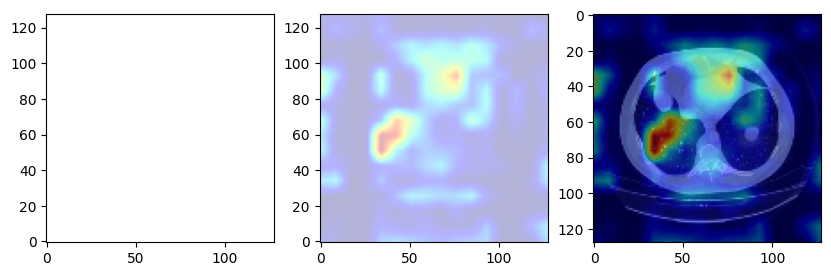

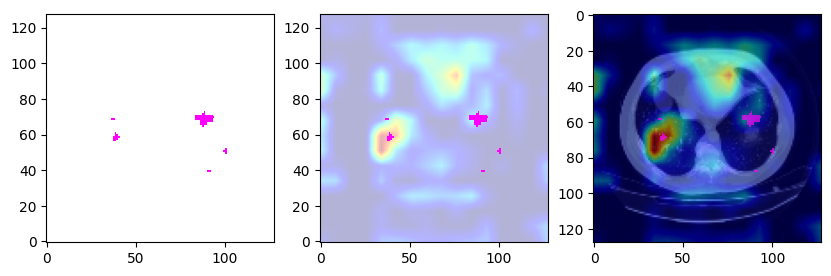

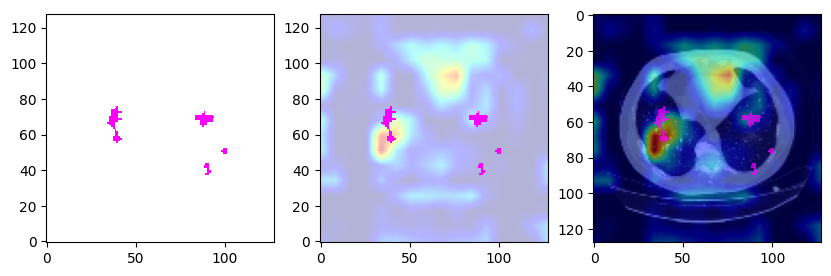

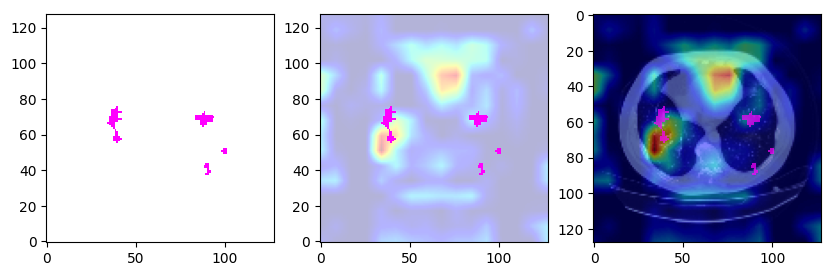

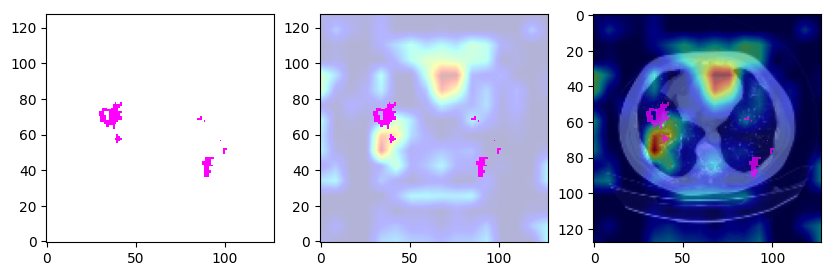

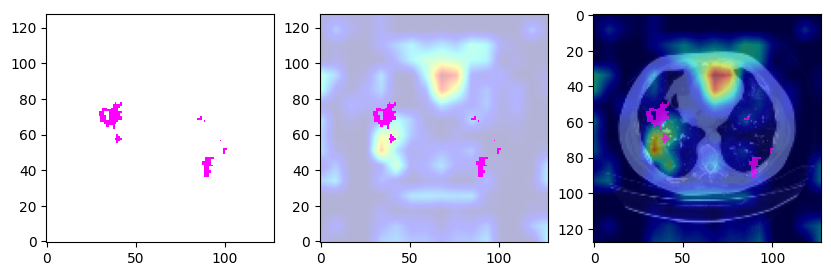

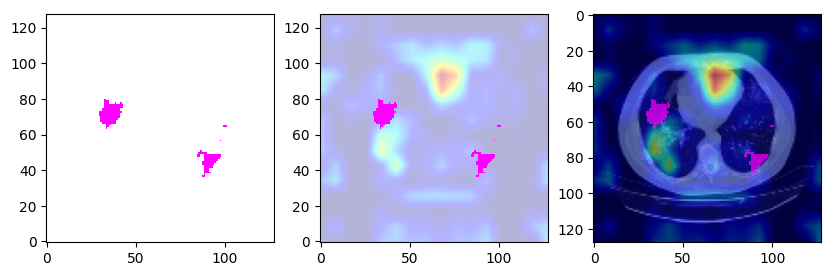

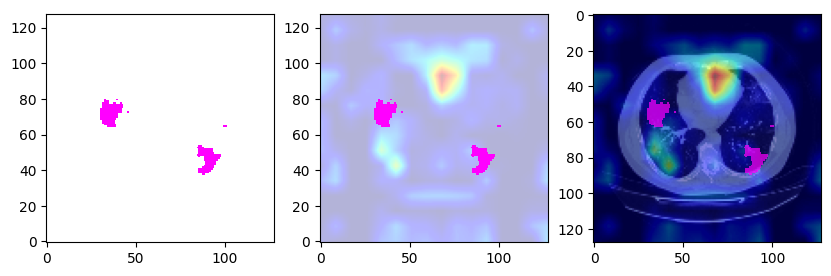

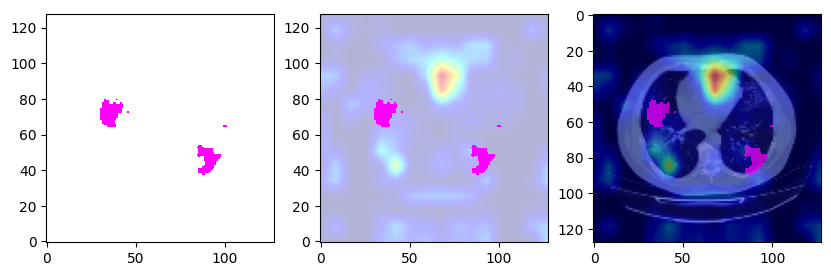

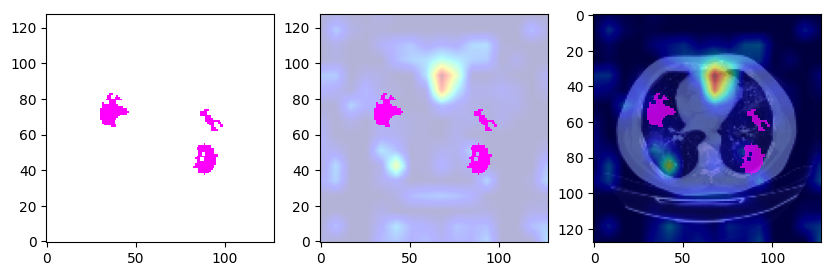

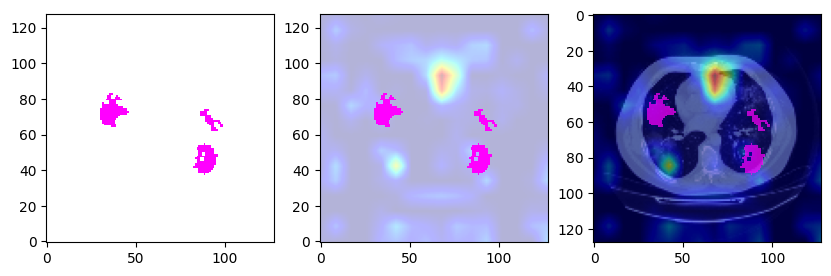

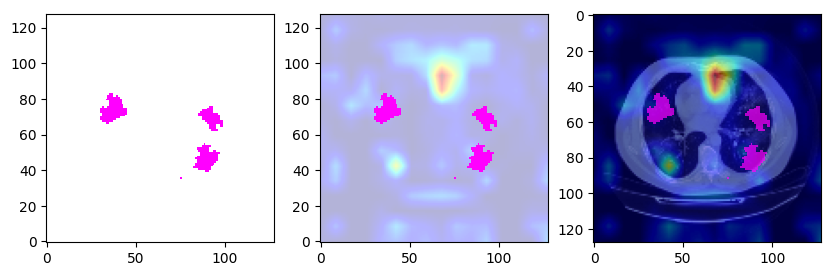

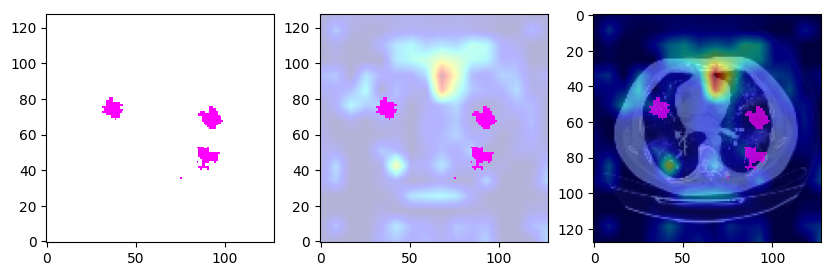

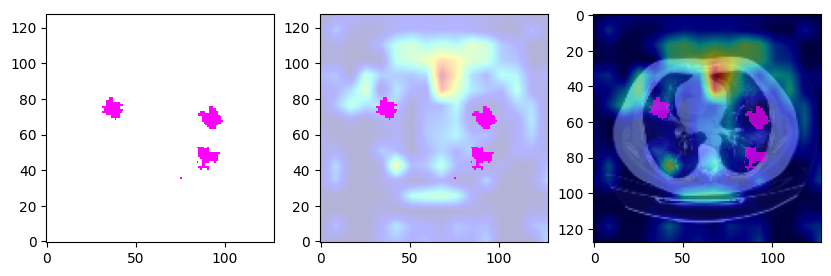

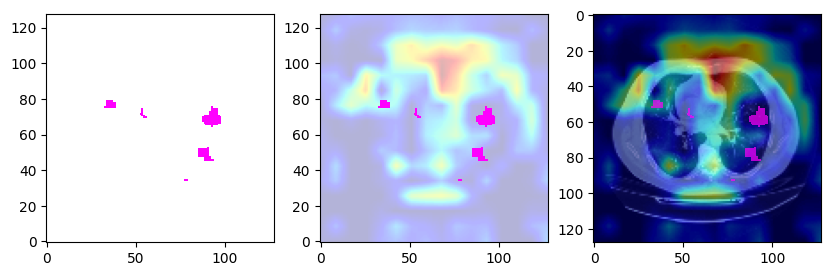

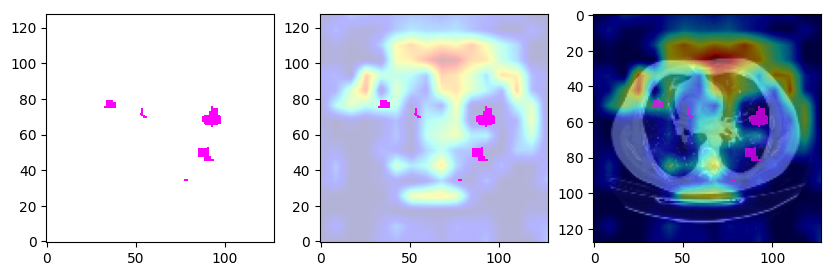

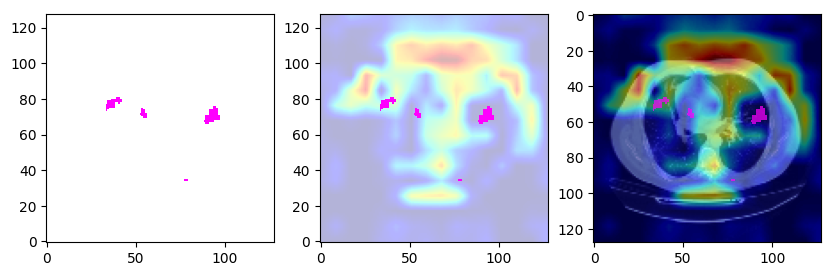

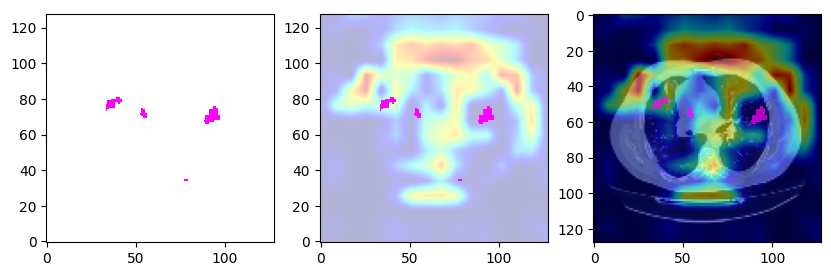

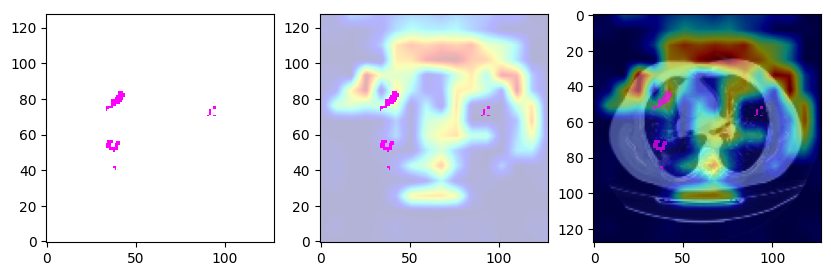

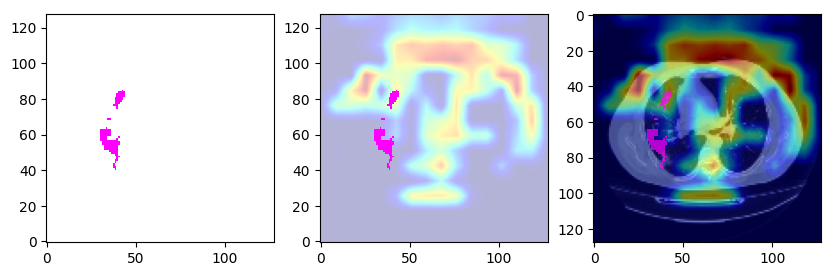

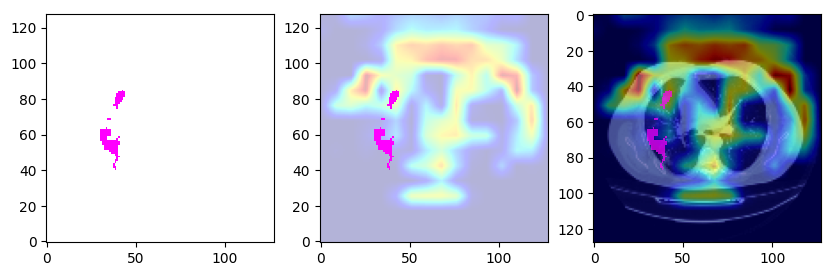

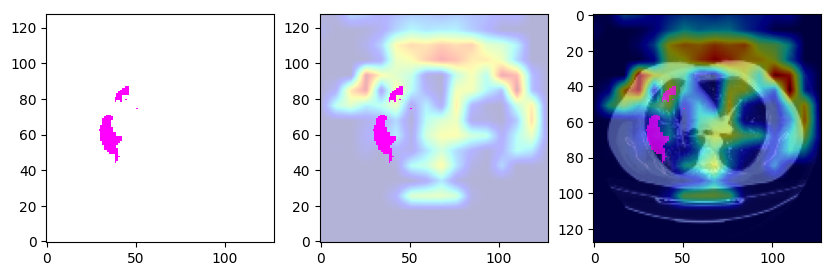

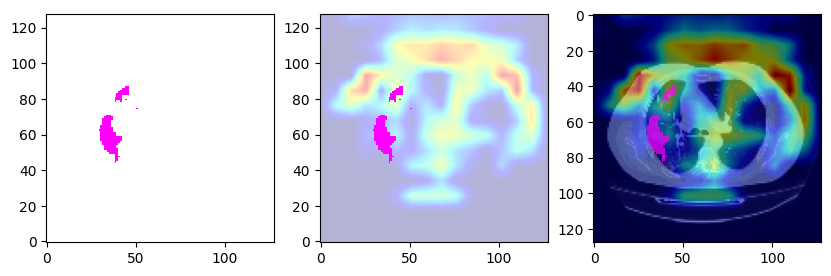

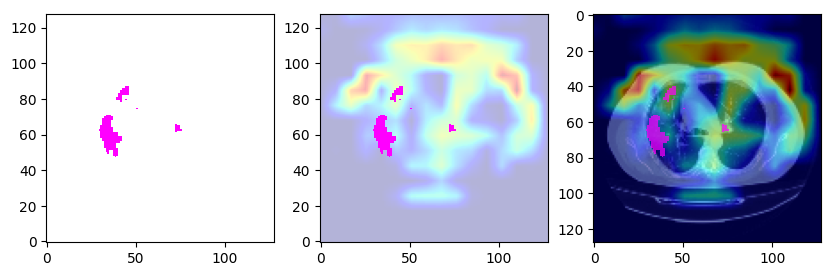

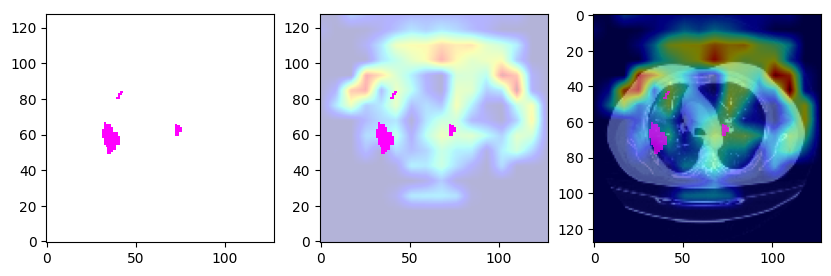

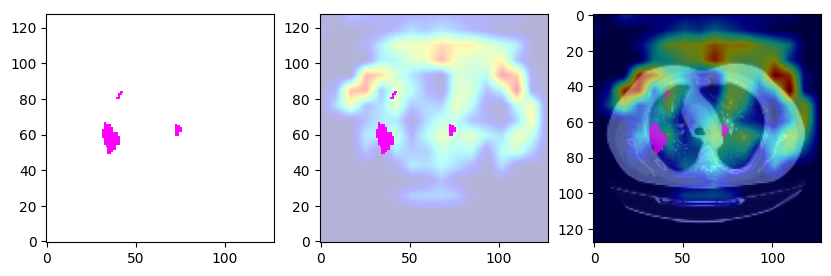

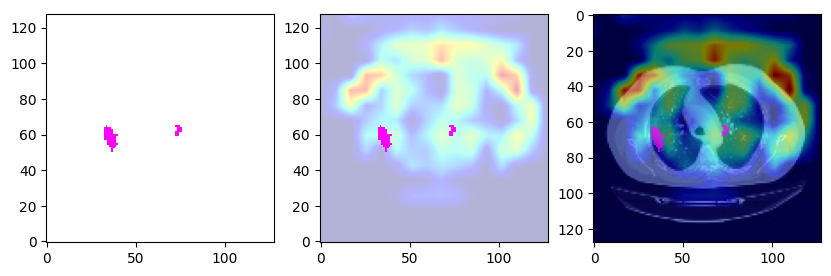

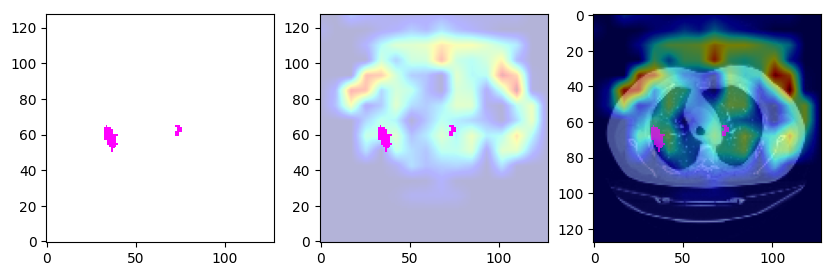

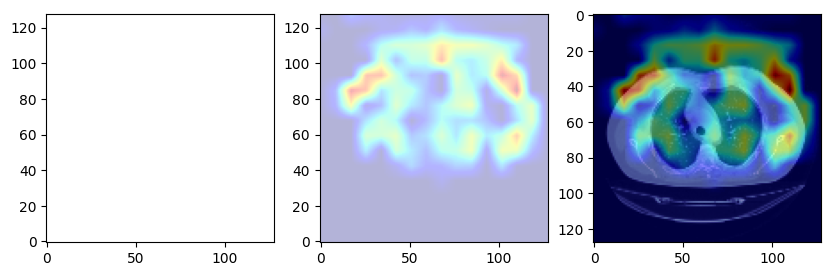

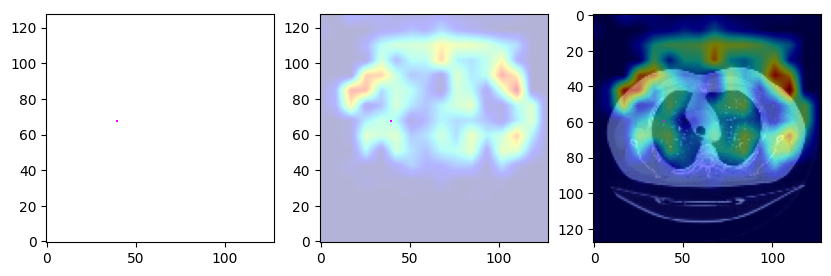

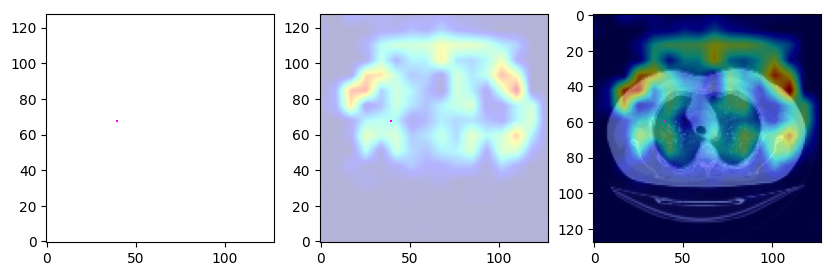

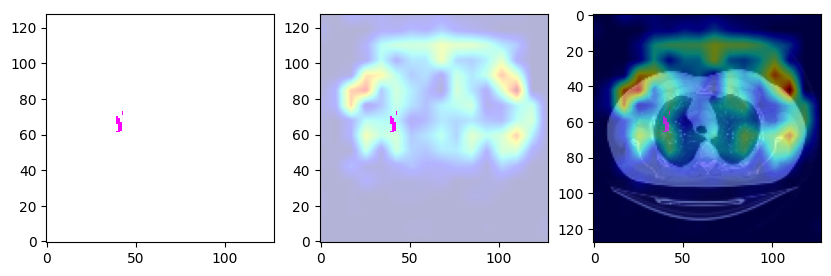

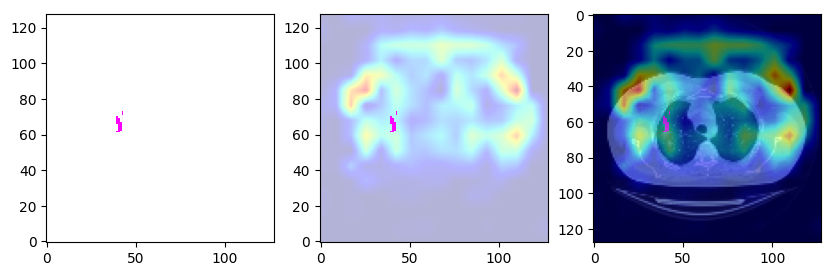

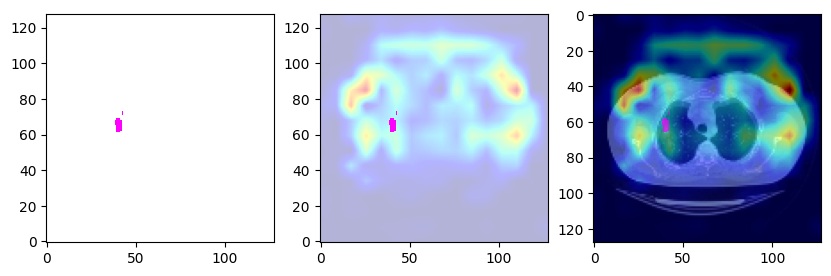

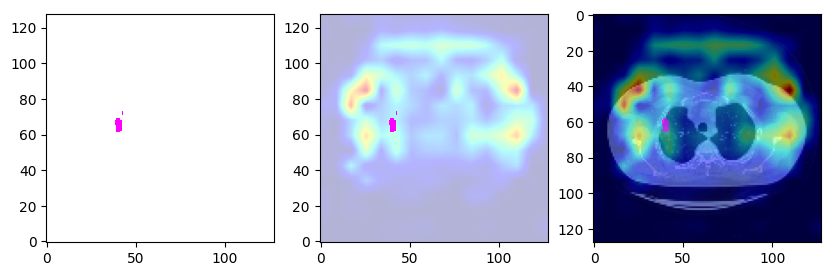

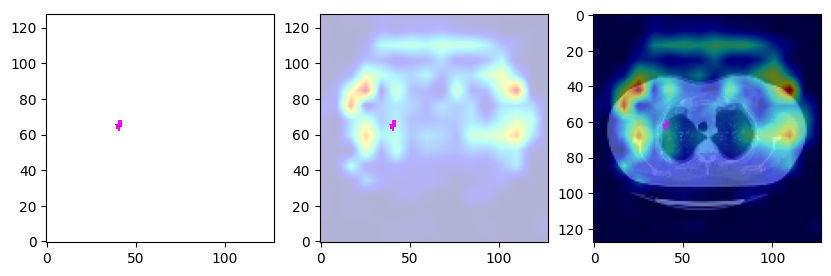

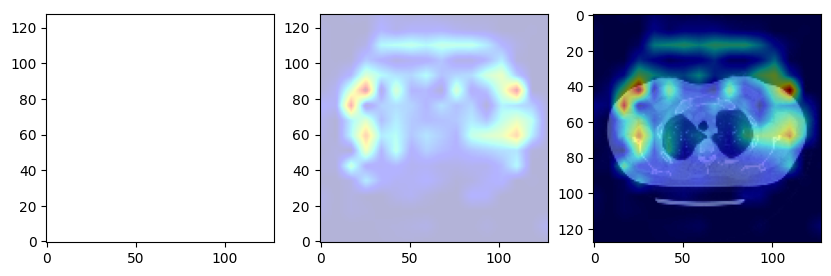

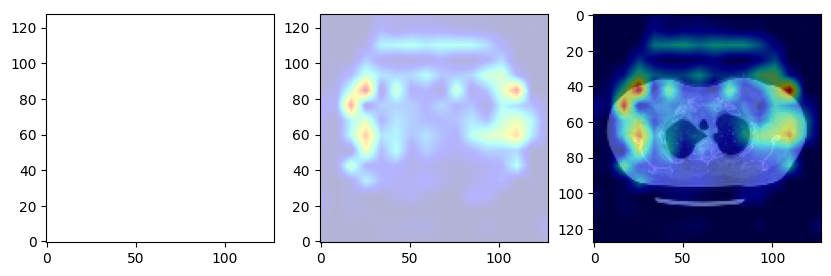

In [66]:
# Assuming mask values are 0 and 1, convert to yellow (1) and black (0)
mask_test = np.where(np.abs(mask_test_volume) < 1e-15, 0, 1)
indices = np.where(mask_test == 1)
indices_list = list(zip(*indices))
arr = [i[2] for i in indices_list]
print(len(indices_list),np.unique(arr))


mask_test = np.where(mask_test == 1, 1, np.nan)  # Set non-1 values to NaN for transparency

for i in range(np.min(np.unique(arr)),np.max(np.unique(arr))+1):
    fig, ax = plt.subplots(1, 3, figsize=(10, 20))

    ax[0].imshow(np.squeeze(mask_test[:, :, i]),  cmap='spring', origin='lower')
    
    img3 = ax[1].imshow(np.squeeze(resized_heatmap[:, :, i]), cmap='jet', alpha=0.3, origin='lower')
    img4 = ax[1].imshow(np.squeeze(mask_test[:, :, i]),  cmap='spring', origin='lower', extent=img3.get_extent())
    
    img0 = ax[2].imshow(np.squeeze(test_sample[:, :, i]), cmap='bone')
    img1 = ax[2].imshow(np.squeeze(resized_heatmap[:, :, i]), cmap='jet', origin='lower', alpha=0.5, extent=img0.get_extent())
    img2 = ax[2].imshow(np.squeeze(mask_test[:, :, i]),  cmap='spring',alpha=0.7, origin='lower', extent=img0.get_extent())
    
    

    plt.show()

8092 [16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39
 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54]
[ 0  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
[ 1. nan]


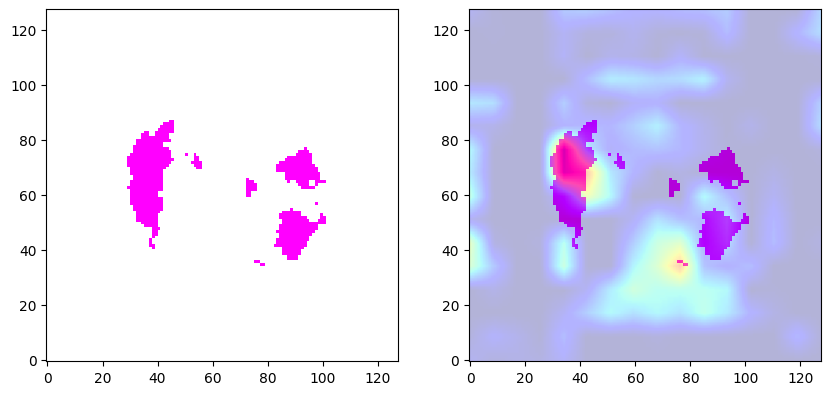

In [67]:
mask_test = np.where(np.abs(mask_test_volume) < 1e-15, 0, 1)
indices = np.where(mask_test == 1)
indices_list = list(zip(*indices))
arr = [i[2] for i in indices_list]
print(len(indices_list),np.unique(arr))

# Assuming mask values are 0 and 1, convert to yellow (1) and black (0)

# mask_test = np.where(mask_test == 1, 1, 0)  # Set non-1 values to NaN for transparency
# print(np.unique(mask_test))
mask_test = np.sum(mask_test, axis=2)
print(np.unique(mask_test))
mask_test = np.where(mask_test > 0, 1, np.nan) 
print(np.unique(mask_test))

# mask_test = np.nan_to_num(mask_test, nan=0)
# print(np.unique(mask_test))

fig, ax = plt.subplots(1, 2, figsize=(10, 20))

ax[0].imshow(np.squeeze(mask_test[:, :]),  cmap='spring', origin='lower')
img0 = ax[1].imshow(np.squeeze(mask_test[:, :]),  cmap='spring', origin='lower')
img1 = ax[1].imshow(np.squeeze(resized_heatmap[:, :, 18]), cmap='jet', alpha=0.3, extent=img0.get_extent())
plt.show()
